# Part 1: APOGEE Selection Function Calculation

This notebook is the first part of three for reproducing [Imig et al 2023](http://astronomy.nmsu.edu/jimig/Imig_MW_density.pdf). In this notebook, we calculate the APOGEE Raw and Effective Selection Functions.

More here...

Note config file!!!


Tale of Contents:
- **1A: Calculate the Raw Selection Function**
    - The Raw Selection Function, the selection fraction as a function of APOGEE targeting parameters: position on sky, apparent H mag and (J-K) color. Computing this usually takes several hours.
- **1B: Calculate the Effective Selection Function**
    - text text

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import dill as pickle
import astropy.io.fits as fits
import time
import pandas as pd
import mwdust
import multiprocessing as mp
from tqdm import tqdm
from numba import jit

from sample_selection import set_env_variables, setup_maap_bins, distmod_bins
set_env_variables()

import apogee.select as apsel
import apogee.tools.read as apread


/Users/jimig/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
#Define Plotting Parameters
params = {'axes.labelsize': 36, 'xtick.labelsize': 36, 'ytick.labelsize': 36, 
          'text.usetex': False, 'lines.linewidth': 1,
          'axes.titlesize': 22, 'font.family': 'serif', 'font.size': 36}
plt.rcParams.update(params)

# Config Settings

In [3]:
# parallelize: use multiprocessing for calculating effective selection function (recommended)
parallelize = False

# savename: file format for saving effective selection function
# in format '{savename}_{bin number}.npz'
savename = 'apogee_effsel'

# Clobber: if TRUE, deletes all files and starts over from scratch
clobber = False

# dmap: choose your Dustmap
dmap = mwdust.Combined19()


# 1A: Calculate the Raw Selection Function

Text text text...

This step usually takes several hours.

In [4]:
# Only calculate if path doesn't exist
if os.path.exists('selfuncs/apogeeCombinedSF.dat'):
    with open('selfuncs/apogeeCombinedSF.dat', 'rb') as f:
        apogee_selfunc = pickle.load(f)
else:
    allstar = apread.allStar(main=True, rmdups=True)
    apogee_selfunc = apsel.apogeeCombinedSelect(year=10)
    with open('selfuncs/apogeeCombinedSF.dat', 'wb') as f:
        pickle.dump(apogee_selfunc, f)

### Plot and Verify the Raw Selection Function

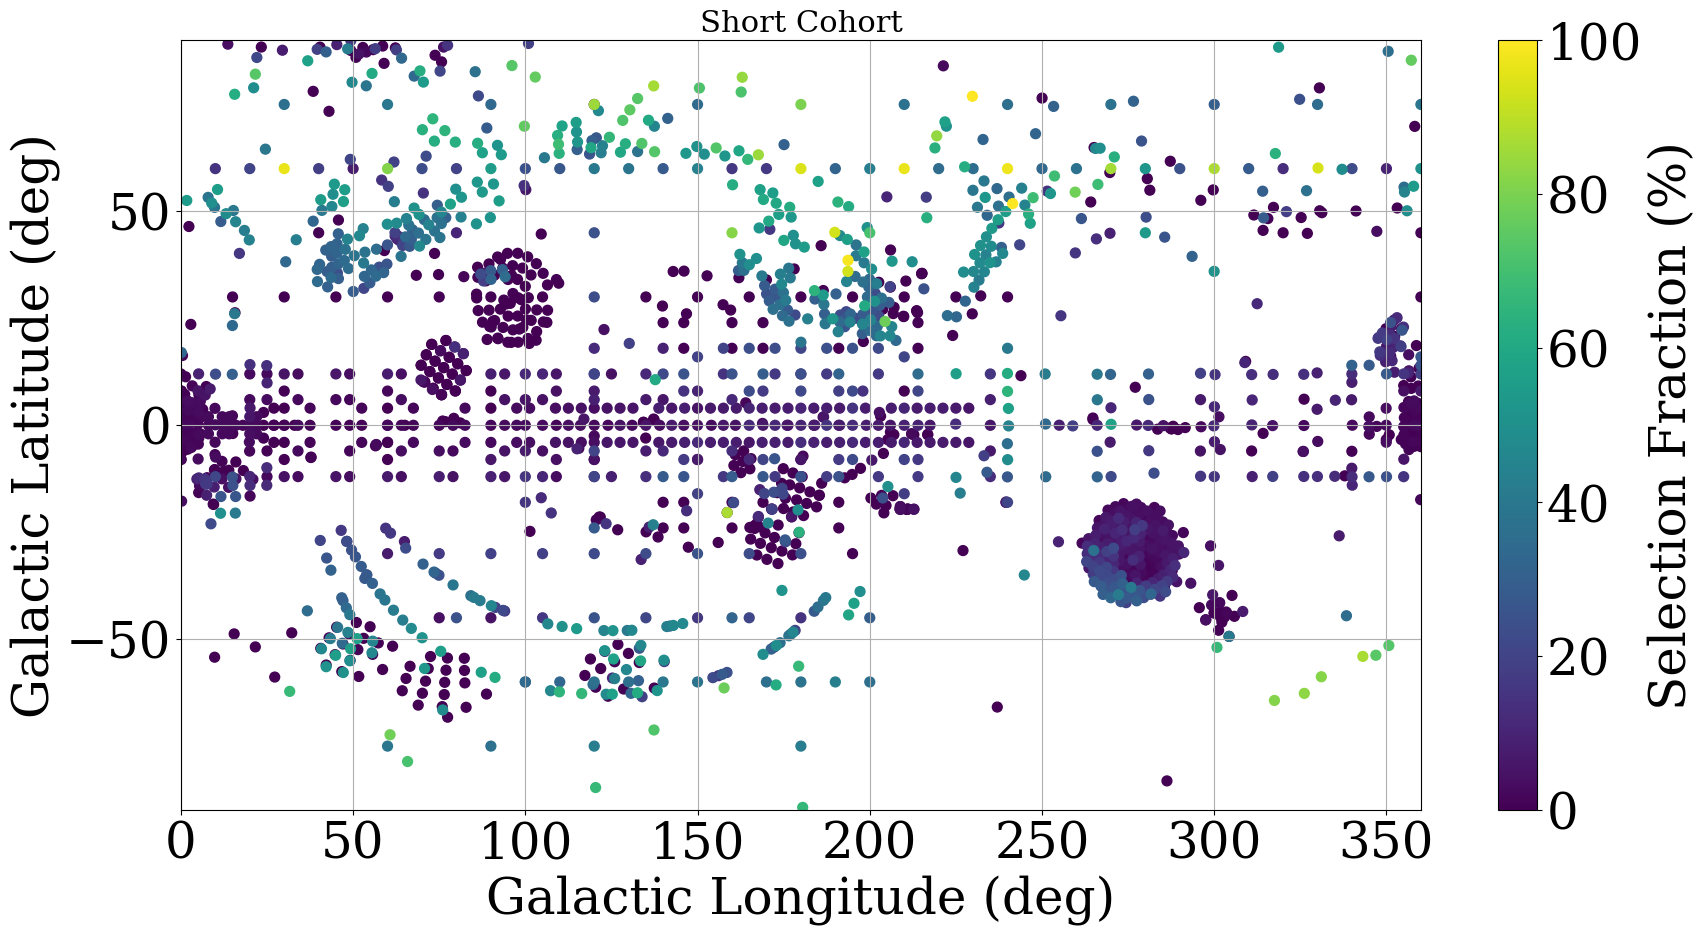

In [5]:
#Coordinates in glon and glat
aposel_glons = np.array([apogee_selfunc.glonGlat(x)[0][0] for x in apogee_selfunc._locations])
aposel_glats = np.array([apogee_selfunc.glonGlat(x)[1][0] for x in apogee_selfunc._locations])

sel_fractions = (apogee_selfunc._nspec_short/apogee_selfunc._nphot_short).T[0]*100

plt.figure(figsize=(20,10))
idx = np.argsort(sel_fractions)
plt.scatter(aposel_glons[idx],aposel_glats[idx],
            c=sel_fractions[idx],vmin=0,vmax=100,cmap='viridis',
            s=50)

plt.colorbar(label='Selection Fraction (%)')
plt.title('Short Cohort')
plt.grid()
plt.xlim(0,360)
plt.ylim(-90,90)
plt.xlabel('Galactic Longitude (deg)')
plt.ylabel('Galactic Latitude (deg)')

plt.show()

## 1B: Calculate the Effective Selection Function

In [6]:
JHK_iso = pd.read_csv('isochrones/parsec_v3.dat', sep='\s+', comment='#')

print("Isochrones cover:")
print(f"[M/H]: {np.sort(list(set(JHK_iso['MH'])))}")
print(f"log(age): {np.sort(list(set(JHK_iso['logAge'])))}")

Isochrones cover:
[M/H]: [-0.95 -0.85 -0.75 -0.65 -0.55 -0.45 -0.35 -0.25 -0.15 -0.05  0.05  0.15
  0.25  0.35  0.45]
log(age): [ 9.05  9.15  9.25  9.35  9.45  9.55  9.65  9.75  9.85  9.95 10.05 10.15]


In [7]:
def add_deltaM_column(iso):
    '''Adds a deltaM column to the isochrones'''
    deltaM = []
    for i in range(len(iso['MH'])):
        if (np.array(iso['MH'])[i-1]==np.array(iso['MH'])[i])&(np.array(iso['logAge'])[i-1]==np.array(iso['logAge'])[i])==True:
            deltaM.append(np.array(iso['int_IMF'])[i]-np.array(iso['int_IMF'])[i-1])
        else:
            deltaM.append(np.array(iso['int_IMF'])[i+1]-np.array(iso['int_IMF'])[i])
            
    return np.array(deltaM)

all_deltaMs = add_deltaM_column(JHK_iso)

In [8]:
def effsel_per_loc(i):
    '''
    computes the effective selection function along the line of sight of one APOGEE location.
    '''
    pbar.update(1)
    loc = all_locations[i]
    jkmin = apogee_selfunc.JKmin(loc)
    
    # No observations
    if np.sum([np.nansum(apogee_selfunc._nspec_short[i]),
               np.nansum(apogee_selfunc._nspec_medium[i]),
               np.nansum(apogee_selfunc._nspec_long[i])]) < 1.:
        effsel = np.zeros(len(ds))
    
    # Valid color bin   
    if np.isfinite(jkmin):
        #cut isochrone based on color bins
        isom = np.where((J-K) >= jkmin)[0]
        norm_weights = weights[isom]/np.nansum(weights[isom])
        effsel = apof.__call__(loc, ds, MH=H[isom], JK0=(J-K)[isom], weights=norm_weights)#*apo.area(loc)

    # Color bin Nan    
    else:
        #print(f'WARNING: Unknown colorbin {jkmin} for location {loc} ???')
        effsel = np.ones(len(ds))*np.nan

    #except: #something else crashed, idk. something wrong with isochrone points?? need to fix this someday
    #        #print('WARNING: Unknown error for location {} with colorbin {} ???'.format(loc,apo.JKmin(loc)))
    #        effsel = np.ones(len(ds))*np.nan

    #print(effsel)
    return effsel

In [9]:
if clobber:
    os.system('rm selfuncs/effsel_bins/*.npz')

In [10]:
# Set up some parameters
Nthreads = mp.cpu_count()

bini = 0
all_locations = apogee_selfunc._locations
# redo some bins
redo_bins = []

# MAAP bin definition
age_bins, mh_bins = setup_maap_bins()
N_bins = len(age_bins['center'])*len(mh_bins['center'])

# logg limits
apogee_sample = fits.open('apogee_sample.fits')[1].data
logg_min_lim = np.min(apogee_sample['LOGG'])
logg_max_lim = np.max(apogee_sample['LOGG'])

# Distance mod bins
ndistmods, ds, distmods, minmax_distmods = distmod_bins()


In [11]:
apogee_sample

FITS_rec([('2M00000002+7417074', 1.03000000e-04, 74.285408, -0.14768, 0.036922, 0.9045983, 3723.9111, 6.12870952, 9.78736904, 6.12870952, 3.26860099,  -9.69119464, 2.78775509,  0.6914106 , 10.08418723, 'LOW', -0.15,  8, 5.62341325, 7),
          ('2M00000068+5710233', 2.85000000e-03, 57.173164, -0.16008, 0.055704, 3.456132 , 5031.2637, 3.31389343, 9.52033854, 3.31389343, 0.71501217,  -8.43412299, 0.64032548, -0.04074918,  8.45839508, 'LOW', -0.15,  8, 3.54813389, 5),
          ('2M00000133+5721163', 5.55800000e-03, 57.354549, -0.51314, 0.10715 , 2.3882506, 4974.601 , 3.56484776, 9.55204099, 3.56484776, 5.923955  , -10.71229316, 5.30488148, -0.47084894, 11.95386934, 'LOW', -0.55,  4, 3.54813389, 5),
          ...,
          ('2M23595837+5700444', 3.59993224e+02, 57.012356, -0.33643, 0.088357, 2.474665 , 4954.17  , 3.06884868, 9.48697547, 3.06884868, 4.274959  ,  -9.98536047, 3.82869939, -0.35883655, 10.694221  , 'LOW', -0.35,  6, 2.81838293, 4),
          ('2M23595886+5726058', 3.599952

In [12]:
for i_f,f in enumerate(mh_bins['center']):
    for i_a,a in enumerate(age_bins['center']):
        log_a = round(np.log10(a*1e9),2)
        f = round(f,2)
        print('='*50)
        print(f'Bin {bini+1}/{N_bins}')
        print(f'[M/H] = {f} , logAge = {log_a}')
        print('='*50)
        bin_data_mask = (apogee_sample['METAL_BIN_I']==i_f)&(apogee_sample['AGE_BIN_I']==i_a)
        starcount1 = len(apogee_sample[bin_data_mask&(apogee_sample['ALPHA_BIN']=='LOW')])
        starcount2 = len(apogee_sample[bin_data_mask&(apogee_sample['ALPHA_BIN']=='HIGH')])
        if (starcount1<100)&(starcount2<100): #no stars, no need for SF
            print(f'{starcount1} + {starcount2} stars. Skipping bin.')
        else:                
            fname = f'selfuncs/effsel_bins/{savename}_{bini}.npz'
            if (os.path.exists(fname) == False)&(bini not in redo_bins):
                iso_mask = (JHK_iso['MH']==f)&(JHK_iso['logAge']==log_a)
                iso_mask = iso_mask&(JHK_iso['logg']<=logg_max_lim)&(JHK_iso['logg']>=logg_min_lim)
                iso_mask = np.where(iso_mask)[0]
                bin_iso = JHK_iso.iloc[iso_mask]
                deltaMs = all_deltaMs[iso_mask]
                m = deltaMs>0
                H,J,K = bin_iso['Hmag'][m],bin_iso['Jmag'][m],bin_iso['Ksmag'][m]
                weights = deltaMs[m]/np.sum(deltaMs[m])
                effsel_array = np.zeros((len(all_locations),ndistmods))
                H = np.array(H)
                J = np.array(J)
                K = np.array(K)
                # Initiate Selection Function
                apof = apsel.apogeeEffectiveSelect(apogee_selfunc, dmap3d=dmap, 
                    MH=H, JK0 = (J-K), weights = weights)


                pbar = tqdm(total=len(all_locations),position=0, leave=True)

                if parallelize:
                    with mp.Pool(Nthreads) as p:
                        effsel_array = p.map(effsel_per_loc, range(len(all_locations)))

                else:
                    for i in range(len(all_locations)):
                        effsel_array[i] = effsel_per_loc(i)

                print(f'Saving {fname}')
                np.savez(fname, np.array(effsel_array))     
            else:
                print('Already done.')
            
        bini+=1

Bin 1/180
[M/H] = -0.95 , logAge = 9.05
0 + 1 stars. Skipping bin.
Bin 2/180
[M/H] = -0.95 , logAge = 9.15
0 + 3 stars. Skipping bin.
Bin 3/180
[M/H] = -0.95 , logAge = 9.25
0 + 3 stars. Skipping bin.
Bin 4/180
[M/H] = -0.95 , logAge = 9.35
0 + 5 stars. Skipping bin.
Bin 5/180
[M/H] = -0.95 , logAge = 9.45
0 + 9 stars. Skipping bin.
Bin 6/180
[M/H] = -0.95 , logAge = 9.55
0 + 15 stars. Skipping bin.
Bin 7/180
[M/H] = -0.95 , logAge = 9.65
0 + 19 stars. Skipping bin.
Bin 8/180
[M/H] = -0.95 , logAge = 9.75
0 + 33 stars. Skipping bin.
Bin 9/180
[M/H] = -0.95 , logAge = 9.85
0 + 70 stars. Skipping bin.
Bin 10/180
[M/H] = -0.95 , logAge = 9.95


  0%|                                                                                               | 0/1937 [00:00<?, ?it/s]

ModuleNotFoundError: This function requires healpy to be installed

In [13]:
import healpy

ModuleNotFoundError: No module named 'healpy'

In [46]:
# Concatenate into one total file
#...
all_effels = []

bini = 0
for i_f,f in enumerate(feh_bins_center):
    for i_a,a in enumerate(age_bins_center):
        fname = f'selfuncs/effsel_bins/{savename}_{bini}.npz'
        effsel_bini = np.load(fname)['arr_0']
        all_effels.append(effsel_bini)
        bini+=1

np.savez('selfuncs/effsel_allbins.npz', np.array(all_effels))

NameError: name 'feh_bins_center' is not defined

In [47]:
import healpy

ImportError: dlopen(/Users/jimig/anaconda3/lib/python3.10/site-packages/healpy/_healpy_sph_transform_lib.cpython-310-darwin.so, 0x0002): Library not loaded: /private/var/folders/pt/4pxym4x563d4rqpwzshf5dkh0001rb/T/pip-install-8e26lnsd/healpy_a39cd56a4eed440686c09934c94849ad/build/temp.macosx-10.9-x86_64-cpython-310/lib/libsharp.2.dylib
  Referenced from: <071600A4-CB6C-3C97-BEDE-5934D556DF72> /Users/jimig/anaconda3/lib/python3.10/site-packages/healpy/_healpy_sph_transform_lib.cpython-310-darwin.so
  Reason: tried: '/private/var/folders/pt/4pxym4x563d4rqpwzshf5dkh0001rb/T/pip-install-8e26lnsd/healpy_a39cd56a4eed440686c09934c94849ad/build/temp.macosx-10.9-x86_64-cpython-310/lib/libsharp.2.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/private/var/folders/pt/4pxym4x563d4rqpwzshf5dkh0001rb/T/pip-install-8e26lnsd/healpy_a39cd56a4eed440686c09934c94849ad/build/temp.macosx-10.9-x86_64-cpython-310/lib/libsharp.2.dylib' (no such file), '/private/var/folders/pt/4pxym4x563d4rqpwzshf5dkh0001rb/T/pip-install-8e26lnsd/healpy_a39cd56a4eed440686c09934c94849ad/build/temp.macosx-10.9-x86_64-cpython-310/lib/libsharp.2.dylib' (no such file), '/usr/local/lib/libsharp.2.dylib' (no such file), '/usr/lib/libsharp.2.dylib' (no such file, not in dyld cache)